#Step 1: Install Required Libraries

In [3]:
!pip install -q tensorflow scipy matplotlib seaborn


#Step 2: Import Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import files

sns.set(style='whitegrid')


#Step 3: Load Dataset and Preprocessing Function

In [5]:
def load_svhn_mat(filepath):
    data = scipy.io.loadmat(filepath)
    images = np.transpose(data['X'], (3, 0, 1, 2)) / 255.0  # Normalize
    labels = data['y'].flatten()
    labels[labels == 10] = 0  # Replace 10 with 0
    return images, labels

def preprocess_data(X, y, one_hot=True, num_classes=10):
    if one_hot:
        y = to_categorical(y, num_classes)
    return X, y


#Step 4: Load & Preprocess Train/Test Sets

In [6]:
# Load
X_train_raw, y_train_raw = load_svhn_mat('train_32x32.mat')
X_test, y_test = load_svhn_mat('test_32x32.mat')

# Preprocess
X_train, y_train = preprocess_data(X_train_raw, y_train_raw)
X_test, y_test_cat = preprocess_data(X_test, y_test)

# Split train into train/validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


#Step 5: Display 10 Random Images

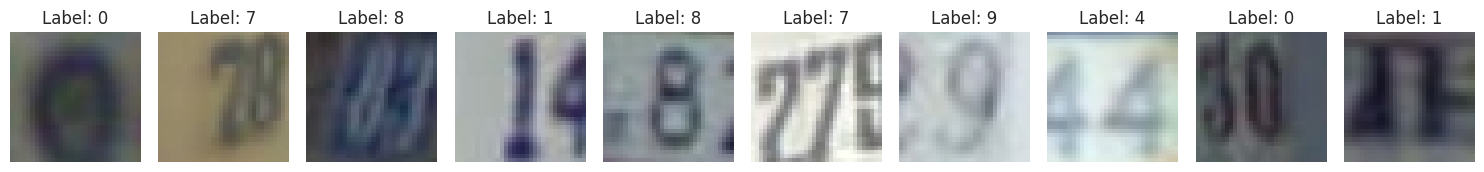

In [7]:
def show_random_images(X, y, n=10):
    idxs = np.random.choice(len(X), n)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i + 1)
        plt.imshow(X[idx])
        plt.title(f"Label: {np.argmax(y[idx])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_random_images(X_train, y_train)


#  Step 6: Define the CNN Model

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Step 7: Compile the Model

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,13

 Total params: 1,343,018 (5.12 MB)

 Trainable params: 1,342,122 (5.12 MB)

 Non-trainable params: 896 (3.50 KB)

#Step 8: Set Callbacks

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

#Step 9: Train the Model

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=128,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)


Epoch 1/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.3041 - loss: 2.2213 - val_accuracy: 0.8082 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 2/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8148 - loss: 0.6074 - val_accuracy: 0.8909 - val_loss: 0.3642 - learning_rate: 0.0010
Epoch 3/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8621 - loss: 0.4498 - val_accuracy: 0.9073 - val_loss: 0.3059 - learning_rate: 0.0010
Epoch 4/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8875 - loss: 0.3801 - val_accuracy: 0.9109 - val_loss: 0.3028 - learning_rate: 0.0010
Epoch 5/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9007 - loss: 0.3368 - val_accuracy: 0.9258 - val_loss: 0.2581 - learning_rate: 0.0010
Epoch 6/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9099 - loss: 0.3148 - val_accuracy: 0.9156 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 7/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9142 - loss

 Step 10: Plot Training History

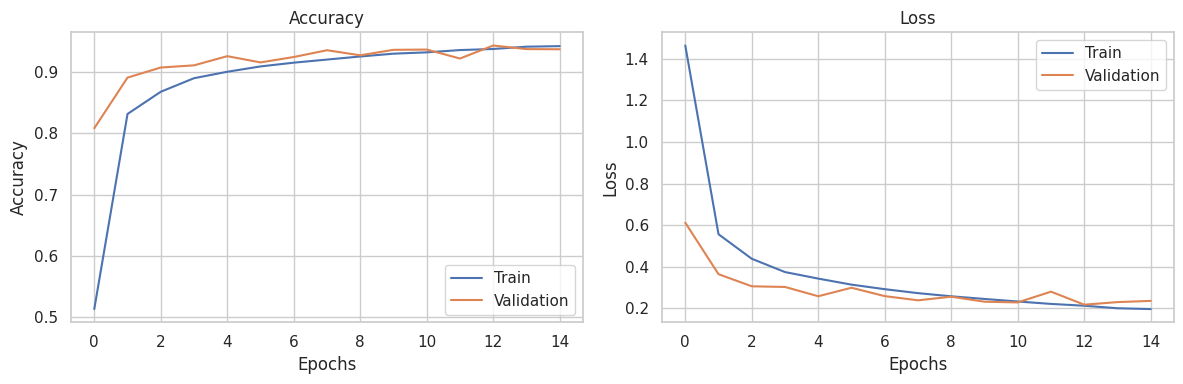

In [12]:
def plot_history(hist):
    plt.figure(figsize=(12, 4))
    for i, metric in enumerate(['accuracy', 'loss']):
        plt.subplot(1, 2, i + 1)
        plt.plot(hist.history[metric], label='Train')
        plt.plot(hist.history[f'val_{metric}'], label='Validation')
        plt.title(metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


#step 11: Evaluate on Test Set

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")


✅ Test Accuracy: 0.9464


#Step 12: Confusion Matrix & Classification *Report*

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


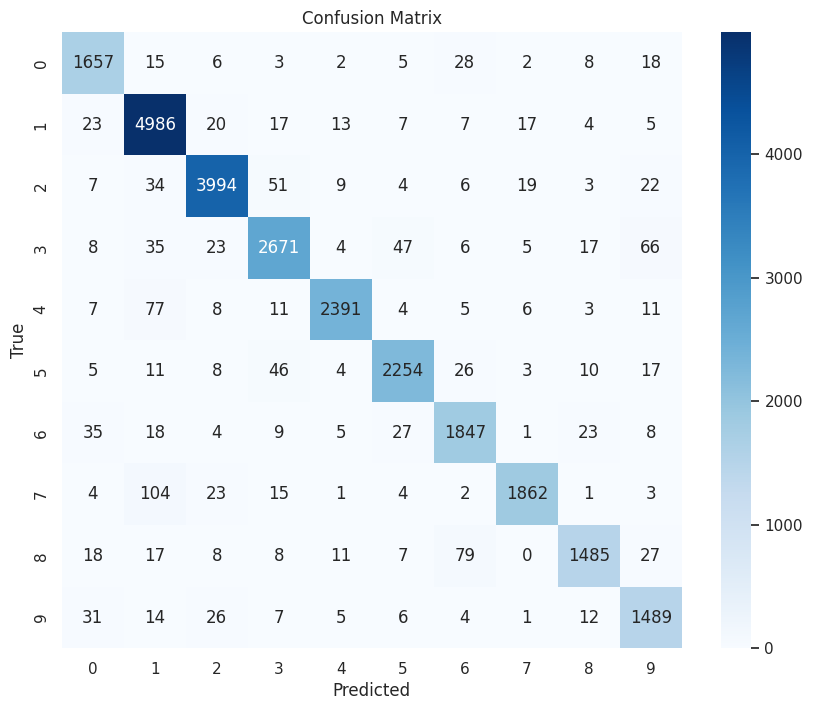

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1744
           1       0.94      0.98      0.96      5099
           2       0.97      0.96      0.97      4149
           3       0.94      0.93      0.93      2882
           4       0.98      0.95      0.96      2523
           5       0.95      0.95      0.95      2384
           6       0.92      0.93      0.93      1977
           7       0.97      0.92      0.95      2019
           8       0.95      0.89      0.92      1660
           9       0.89      0.93      0.91      1595

    accuracy                           0.95     26032
   macro avg       0.94      0.94      0.94     26032
weighted avg       0.95      0.95      0.95     26032



In [14]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred))


#Step 13: Show Misclassified Images

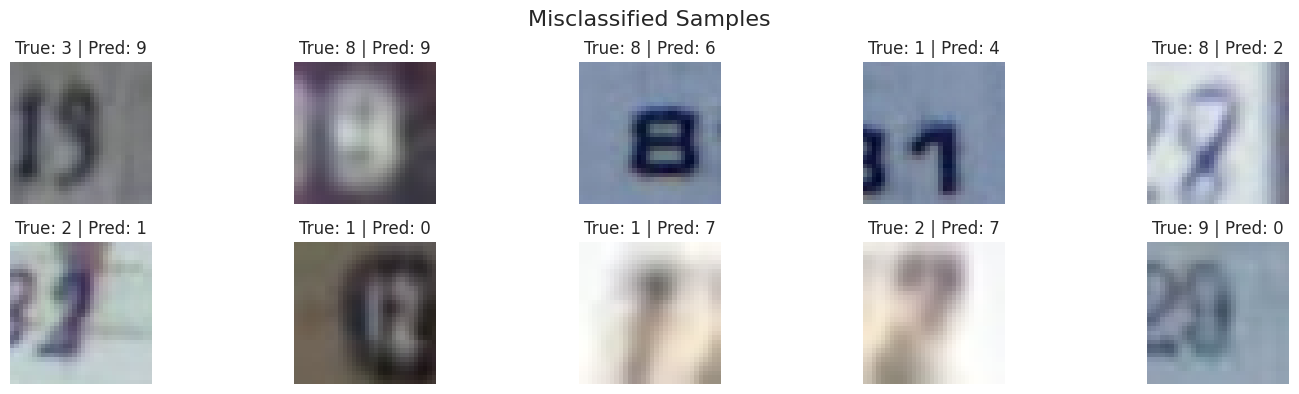

In [17]:
misclassified_idx = np.where(y_pred != y_test)[0][:10]

plt.figure(figsize=(15, 4))
for i, idx in enumerate(misclassified_idx):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_test[idx]} | Pred: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Add spacing for the suptitle
plt.suptitle("Misclassified Samples", fontsize=16)
plt.show()
